### Preprocess Gridded Data to find Anomalies and Extreme Values

This notebook provides an example of how one might preprocess gridded sea surface temperature (SST) data to extract anomalies and detect extreme values. Here we will use monthly mean SST from the [NOAA Optimum Interpolation Sea Surface Temperature](https://www.ncdc.noaa.gov/oisst/data-access) (OISST v2.1) dataset. This data is measured from a blend of satellite and in-situ observations. We elect to use data from AVHRR-only satellites. This product is available from September 1981 through present on a 1/4º global regular grid.

In [ ]:
# Import Python libraries
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings('ignore')

### 1. Import data

In [ ]:
# import daily OISST
path = '/glade/scratch/scanh/OISST/'
ds = xr.open_mfdataset(path+'avhrr-only-v2.*.nc', decode_times=True, combine='by_coords')

# calculate monthly mean sst
mnsst = ds.sst.squeeze().resample(time='MS').mean().squeeze()

In [ ]:
mnsst.load()

<xarray.DataArray 'sst' (time: 464, lat: 720, lon: 1440)>
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [-1.3066666, -1.3066666, -1.3073334, ..., -1.3066666,
         -1.3066666, -1.3063333],
        [-1.3096668, -1.3099998, -1.3099998, ..., -1.3093333,
         -1.3093333, -1.3096668],
        [-1.312    , -1.312    , -1.312    , ..., -1.312    ,
         -1.312    , -1.312    ]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
...
        [-1.7780645, -1.7780645, -1.7780645, ..., -1.778387 ,
         -1.778387 , -1.778387 ],
        [-1.778387 , -1.778387 , -1.778387 , ..., -1.778387 ,
         -1.778387 , -1.778387 ],
        [-1.778387 , -1.778387 , -1.778387 , ..., -1.778387 ,
         -1.778387 , -1.778387 ]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [-1.7738461, -1.7738461, -1.7738461, ..., -1.7738461,
         -1.7738461, -1.7738461],
        [-1.7746152, -1.7746152, -1.7746152, ..., -1.7746152,
         -1.7746152, -1.7746152],
        [-1.7749999, -1.7749999, -1.7749999, ..., -1.7749999,
         -1.7749999, -1.7749999]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1981-09-01 1981-10-01 ... 2020-04-01
    zlev     float32 0.0
  * lat      (lat) float32 -89.875 -89.625 -89.375 ... 89.375 89.625 89.875
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.375 359.625 359.875

In [ ]:
# import land mask
dm = xr.open_dataset(path+'lsmask.nc', decode_times=True)
reproject = np.flipud(dm.mask[0, :,:].transpose('lat', 'lon'))
land_mask = xr.DataArray(reproject, dims=['lat','lon'], coords={'lat':dm.lat, 'lon':dm.lon})  


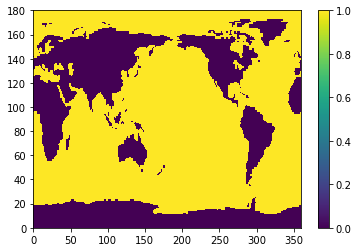

In [ ]:
plt.pcolormesh(land_mask); plt.colorbar()

In [ ]:
years = pd.DatetimeIndex(mnsst.time.values).year
months = pd.DatetimeIndex(mnsst.time.values).month
dyr = []
for i in enumerate(years):
    I = i[1] + ((months[i[0]]-0.5)/12)
    dyr.append(I)
dyr = np.array(dyr)

### 2. Fit mean, trend, annual, and semi-annual harmonics to SST over entire record¶


In [ ]:
# Our 6 coefficient model is composed of the mean, trend, annual sine and cosine harmonics, & semi-annual sine and cosine harmonics
model = np.array([np.ones(len(dyr))] + [dyr-np.mean(dyr)] + [np.sin(2*np.pi*dyr)] + [np.cos(2*np.pi*dyr)] + [np.sin(4*np.pi*dyr)] + [np.cos(4*np.pi*dyr)])

# Take the pseudo-inverse of model to 'solve' least-squares problem
pmodel = np.linalg.pinv(model)

# Convert model and pmodel to xaray DataArray
model_da = xr.DataArray(model.T, dims=['time','coeff'], coords={'time':mnsst.time.values, 'coeff':np.arange(1,7,1)}) 
pmodel_da = xr.DataArray(pmodel.T, dims=['coeff','time'], coords={'coeff':np.arange(1,7,1), 'time':mnsst.time.values})  

# resulting coefficients of the model
sst_mod = xr.DataArray(pmodel_da.dot(mnsst), dims=['coeff','lat','lon'], coords={'coeff':np.arange(1,7,1), 'lat':mnsst.lat.values, 'lon':mnsst.lon.values})  

# Construction of the mean, trend, and seasonal cycle
mean = xr.DataArray(model_da[:,0].dot(sst_mod[0,:,:]), dims=['time','lat','lon'], coords={'time':mnsst.time, 'lat':mnsst.lat.values, 'lon':mnsst.lon.values})   
trend = xr.DataArray(model_da[:,1].dot(sst_mod[1,:,:]), dims=['time','lat','lon'], coords={'time':mnsst.time, 'lat':mnsst.lat.values, 'lon':mnsst.lon.values})    
seas = xr.DataArray(model_da[:,2:].dot(sst_mod[2:,:,:]), dims=['time','lat','lon'], coords={'time':mnsst.time, 'lat':mnsst.lat.values, 'lon':mnsst.lon.values})

/glade/u/home/scanh/miniconda3/envs/ocetrac-2020/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


KeyboardInterrupt: 

### 3. Compute SST anomalies (SSTa) and detrend

In [ ]:
# redefine SST with and without the trend
sst_notrend = xr.DataArray((mnsst-trend).values, dims=['time','lat','lon'], coords={'time':mnsst.time, 'lat':mnsst.lat.values, 'lon':mnsst.lon.values})  
sst_trend = xr.DataArray(mnsst.values, dims=['time','lat','lon'], coords={'time': mnsst.time, 'lat':mnsst.lat.values, 'lon':mnsst.lon.values})  

# compute anomalies (SSTa) by removing model coefficients – with and without the trend
ssta_notrend = xr.DataArray((mnsst.values-model_da.dot(sst_mod)).values, dims=['time','lat','lon'], coords={'time':mnsst.time, 'lat':mnsst.lat.values, 'lon':mnsst.lon.values}) 
ssta_trend = xr.DataArray((mnsst.values-model_da.dot(sst_mod[[0,2,3,4,5],:,:])).values, dims=['time','lat','lon'], coords={'time':mnsst.time, 'lat':mnsst.lat.values, 'lon':mnsst.lon.values})

### 4. Standardized SSTa by dividing by the monthly standard deviation
This step places equal variance on SSTa at all spatial points

In [ ]:
# compute monthly standard deviation
stdev_notrend = ssta_notrend.groupby(ssta_notrend.time.dt.month).std()
stdev_trend = ssta_trend.groupby(ssta_trend.time.dt.month).std()

# Initalize xarray DataArray for SSTa with and without trend
ssta_stn_notrend = np.empty((ssta_notrend.shape[0], ssta_notrend.shape[1], ssta_notrend.shape[2])) 
ssta_stn_notrend[:] = np.nan
ssta_stn_notrend = xr.DataArray(ssta_stn_notrend, dims=['time','lat','lon'], coords={'time':mnsst.time, 'lat':mnsst.lat.values, 'lon':mnsst.lon.values}) 

ssta_stn_trend = np.empty((ssta_trend.shape[0], ssta_trend.shape[1], ssta_trend.shape[2])) 
ssta_stn_trend[:] = np.nan
ssta_stn_trend = xr.DataArray(ssta_stn_trend, dims=['time','lat','lon'], coords={'time':mnsst.time, 'lat':mnsst.lat.values, 'lon':mnsst.lon.values}) 

# Loop over months and divde by standard deviation
for i in np.arange(1,13):
    I = np.where(mnsst.time.dt.month==i)[0]
    ssta_stn_notrend[I,:,:] = ssta_notrend[I,:,:]/stdev_notrend[i-1,:,:]
    ssta_stn_trend[I,:,:] = ssta_trend[I,:,:]/stdev_trend[i-1,:,:]

### 5. Define a threshold to define extreme values
Here we will use the 90th percentile relative to the monthly values over the entire record

In [ ]:
# Define extreme threshold as the 90th percentile
thresh = .9

# Compute values of the monthly threshold
prct_notrend = sst_notrend.groupby(sst_notrend.time.dt.month).quantile(thresh, dim='time', interpolation='linear', keep_attrs=True, skipna=True)
prct_trend = sst_trend.groupby(sst_trend.time.dt.month).quantile(thresh, dim='time', interpolation='linear', keep_attrs=True, skipna=True)

In [ ]:
# Intialize xarray DataArrays for SSTa relative to the threshold defined above in Step 5.
ssta_prc_notrend = np.empty((sst_notrend.shape[0], sst_notrend.shape[1], sst_notrend.shape[2], prct_notrend.shape[3])) 
ssta_prc_notrend[:] = np.nan
ssta_prc_notrend = xr.DataArray(ssta_prc_notrend,
                                dims=('time', 'lat', 'lon','quantile'),
                                coords={'time': sst_notrend.time.values,
                                        'lat': sst_notrend.lat.values,
                                        'lon': sst_notrend.lon.values,
                                        'quantile':thresh}) 

ssta_prc_trend = np.empty((sst_trend.shape[0], sst_trend.shape[1], sst_trend.shape[2], prct_trend.shape[3])) 
ssta_prc_trend[:] = np.nan
ssta_prc_trend = xr.DataArray(ssta_prc_trend,
                              dims=('time', 'lat', 'lon','quantile'),
                              coords={'time': sst_trend.time.values,
                                      'lat': sst_trend.lat.values,
                                      'lon': sst_trend.lon.values,
                                      'quantile':thresh})

In [ ]:
# Loop over months and compute SSTa relative to the threshold defined above in Step 5.  
for i in np.arange(1,13,1):
    I = np.where(mnsst.time.dt.month==i)[0]
    ssta_prc_notrend[I,:,:,:] = sst_notrend[I,:,:]-prct_notrend[i-1,:,:,:] 
    ssta_prc_trend[I,:,:,:] = sst_trend[I,:,:]-prct_trend[i-1,:,:,:]

### 6. Find where the standardized SSTa exceeds the threshold

In [ ]:
# Take only the SSTa that exceeds the calculated monthly threshold
mhw_ssta_notrend = ssta_stn_notrend.where(ssta_prc_notrend>0.)
mhw_ssta_trend = ssta_stn_trend.where(ssta_prc_trend>0.)

### 7. Save the extreme values of SSTa relative to the mean in netCDF format
! Need to add land mask to output

In [ ]:
# Specify path to save output 
save_to = '/glade/scratch/scanh/MHW_pre/'

# Convert xarray DatAarray to Dataset
mhw_ssta_notrend.compute()
mhw_ssta_notrend_ds = mhw_ssta_notrend.to_dataset(name='mhw_ssta_notrend')

mhw_ssta_trend.compute()
mhw_ssta_trend_ds = mhw_ssta_trend.to_dataset(name='mhw_ssta_trend')

# Save Dataset to netCDF
mhw_ssta_notrend_ds.to_netcdf(save_to+'preprocess_mhw_OISSTv2_monthly_notrend_stn.nc', mode='w')
mhw_ssta_notrend_ds.attrs['threshold'] = 0.9

mhw_ssta_trend_ds.to_netcdf(save_to+'preprocess_mhw_OISSTv2_monthly_trend_stn.nc', mode='w')
mhw_ssta_trend_ds.attrs['threshold'] = 0.9